In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install fuzzywuzzy distance nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 180 kB 5.2 MB/s 
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16276 sha256=7496df411c9caa63c7b815244ea1b1b4afc0a2c50114841c4602a17340c70042
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built distance


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS
import distance
from subprocess import check_output
from nltk.stem import PorterStemmer
import os
from os import path
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
df = pd.read_csv('/content/drive/MyDrive/train.csv')
# df = df.fillna('')
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [10]:
df['is_duplicate'].value_counts(normalize=True)

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64

In [11]:
new_df = df.groupby("is_duplicate").sample(n=20000, random_state=1)

In [12]:
new_df['is_duplicate'].value_counts()

0    20000
1    20000
Name: is_duplicate, dtype: int64

In [27]:
# preprocessing
import re
def striphtml(data):
    p = re.compile(r'<.*?>')
    return p.sub('', str(data))
def preprocess(q):
    # q = BeautifulSoup(q)
    # q = q.get_text()
    q = striphtml(q)
    
    q = str(q).lower().strip()

#   replace Special character
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
#   The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')   
    
#   Replacing some numbers with string equivalents 
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
#   Decontracting words.
    contractions = { 
        "ain't": "am not",
        "aren't": "are not",
        "can't": "can not",
        "can't've": "can not have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
        }
    q_decontracted  = []
    
    for word in q.split():
        if word in contractions:
            word = contractions[word]
        q_decontracted.append(word)
    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(q) == type(''):
        q = re.sub(pattern, ' ', q)
    
    
    if type(q) == type(''):
        q = porter.stem(q)

               
    
    return q.strip()

In [14]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [15]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [16]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))


new_df['q1_len'] = new_df['question1'].str.len()  #"Hi I am vijay" len=13
new_df['q2_len'] = new_df['question2'].str.len()
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" "))) #"Hi I am vijay" num_word=5
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))
new_df['word_common'] = new_df.apply(common_words, axis=1)
new_df['word_total'] = new_df.apply(total_words, axis=1)
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
287579,287579,408384,408385,how do you identify aircraft type visually,renouncing work bg 3 1,0,42,22,7,5,0,12,0.00
189055,189055,287722,151188,why do many teenagers feel like they are fat a...,why do so many teenagers have nude photos se...,0,53,57,11,12,4,22,0.18
334080,334080,461244,124430,which bank provides best demat account service...,what is the best demat account service provide...,0,56,56,9,10,5,19,0.26
48072,48072,85760,85761,what can i write in a speech against demonetis...,how can i write a speech against demonetisation,0,51,47,9,8,7,17,0.41
336792,336792,464184,448356,what are the best ways to transition from nega...,if a person want to take a indian citizenship ...,0,81,117,15,24,2,34,0.06


In [17]:
# Advanced Features
from nltk.corpus import stopwords
def fetch_token_features(q1, q2):
#     q1 = row['question1']
#     q2 = row['question2']
    
    SAFE_DIV = 0.0001
    
    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0] * 10
    
#     converting sentance into tokens
    q1_tokens = q1.split()  ##["vijay",'go','market']
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
#     get non-stopwords in Q
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
#     get stopwords in Q
    q1_stop = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stop = set([word for word in q2_tokens if word in STOP_WORDS])

#     common non-stop words
    common_word_count = len(q1_words.intersection(q2_words))

#   common stop words
    common_stop_count = len(q1_stop.intersection(q2_stop))
    
#   Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stop), len(q2_stop)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stop), len(q2_stop)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
#     last word of both Q is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

#   first word of both Q is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    token_features[8] = abs(len(q1_tokens)- len(q2_tokens))

#   avg token length
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    
    return token_features

# longest common sub string
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
    
def extract_features(df):
    
    df['question1'] = df['question1'].fillna('').apply(preprocess)
    df['question2'] = df['question2'].fillna('').apply(preprocess)
    
    print("token featuresss....")
    
#     merging features

    token_features = df.apply(lambda x: fetch_token_features(x['question1'],x['question2']), axis = 1)
    
    df['cwc_min'] = list(map(lambda x: x[0], token_features))
    df['cwc_max'] = list(map(lambda x: x[1], token_features))
    df['csc_min'] = list(map(lambda x: x[2], token_features))
    df['csc_max'] = list(map(lambda x: x[3], token_features))
    df['ctc_min'] = list(map(lambda x: x[4], token_features))
    df['ctc_max'] = list(map(lambda x: x[5], token_features))
    df['last_word_eq'] = list(map(lambda x: x[6], token_features))
    df['first_word_eq'] = list(map(lambda x: x[7], token_features))
    df['abs_len_diff'] = list(map(lambda x: x[8], token_features))
    df['mean_len'] = list(map(lambda x: x[9], token_features))
    
    
    print("fuzzy featuresss....")
    
    
    df['token_set_ratio'] = df.apply(lambda x : fuzz.token_set_ratio(x['question1'],x['question2']),axis = 1)
    df['token_sort_ratio'] = df.apply(lambda x : fuzz.token_sort_ratio(x['question1'],x['question2']),axis = 1)
    df['fuzz_ratio'] = df.apply(lambda x : fuzz.QRatio(x['question1'],x['question2']),axis = 1)
    df['partial_ratio'] = df.apply(lambda x : fuzz.partial_ratio(x['question1'],x['question2']),axis = 1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [20]:
if os.path.isfile('/content/drive/MyDrive/nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')  
    df.dropna(inplace=True)  
else:
    print("Extracting features for train:")
    # df = pd.read_csv("train.csv")
    df = extract_features(new_df)
    df.to_csv("nlp_features_train.csv", index=False)
# df.head(2)

In [7]:
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) 
                                             / start_mem))
    
    import gc 
    gc.collect()
    return df

In [22]:
# the most frequent occuring words
df_duplicate = df[df['is_duplicate'] == 1]
df_Nonduplicate = df[df['is_duplicate'] == 0]

p = np.dstack([df_duplicate['question1'], df_duplicate['question2']]).flatten()
n = np.dstack([df_Nonduplicate['question1'], df_Nonduplicate['question2']]).flatten()

print("Duplicate pairs : ",len(p))
print('Non Duplicate pairs : ',len(n))

np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding='utf-8')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s' , encoding='utf-8')

Duplicate pairs :  40000
Non Duplicate pairs :  39996


In [23]:
# readinf text files and removeing stop words

textp_w = open('train_p.txt' , encoding='utf-8').read()
textn_w = open('train_n.txt', encoding='utf-8').read()

stopwords = set(STOPWORDS)
stopwords.remove('not')
stopwords.remove('no')
stopwords.remove('like')
print("Total number of words in duplicate pair Q :", len(textp_w))
print("Total number of words in non duplicate pair Q :", len(textn_w))

Total number of words in duplicate pair Q : 2062545
Total number of words in non duplicate pair Q : 2495140


WordCloud for duplicate Q pairs


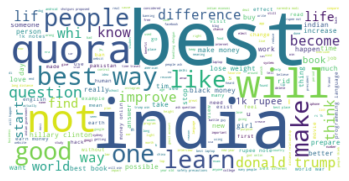

In [24]:
# Word Cloud for duplicate Q pairs 
wc = WordCloud(background_color = 'white', max_words = len(textp_w), stopwords = stopwords)
wc.generate(textp_w)
print("WordCloud for duplicate Q pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

WordCloud for non duplicate Q pairs


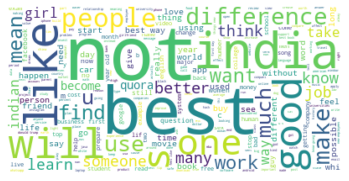

In [25]:
# Word Cloud for non duplicate Q pairs
wc = WordCloud(background_color = 'white', max_words = len(textn_w), stopwords = stopwords)
wc.generate(textn_w)
print("WordCloud for non duplicate Q pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [26]:
ques_df = df[['question1','question2']]
ques_df.head()

,question1,question2
0,how do you identify aircraft type visu,renouncing work bg 3 1
1,why do many teenagers feel like they are fat a...,why do so many teenagers have nude photos self...
2,which bank provides best demat account service...,what is the best demat account service provide...
3,what can i write in a speech against demonetis,how can i write a speech against demonetis
4,what are the best ways to transition from nega...,if a person want to take a indian citizenship ...


In [27]:
final_df = df.drop(columns = ['id','qid1','qid2','question1','question2'])
print(final_df.shape)
final_df.head()

(39998, 23)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,partial_ratio,longest_substr_ratio
0,0,42,22,7,5,0,12,0.00,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,6.0,17,17,20,23,0.086957
1,0,53,57,11,12,4,22,0.18,0.333328,0.333328,...,0.363633,0.0,1.0,1.0,10.5,59,44,54,57,0.314815
2,0,56,56,9,10,5,19,0.26,0.666656,0.571420,...,0.499995,1.0,0.0,1.0,9.5,84,82,73,73,0.473684
3,0,51,47,9,8,7,17,0.41,0.999967,0.999967,...,0.777769,1.0,0.0,1.0,8.5,95,89,91,93,0.627907
4,0,81,117,15,24,2,34,0.06,0.000000,0.000000,...,0.090909,0.0,0.0,7.0,18.5,35,31,37,44,0.061728


In [28]:
final_df = reduce_mem_usage(final_df)

Memory usage of dataframe is 7.32MB
Memory usage after optimization is: 1.79MB
Decreased by 75.5%


In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
# merging text
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = TfidfVectorizer(max_features = 3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2) # 20k Question it will split 1-10K then 10K -20K like that

# q1_arr , q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)
# 3000 q1 and 3000 q2 features

In [30]:
temp_df1 = pd.DataFrame(q1_arr , index = ques_df.index)
temp_df2 = pd.DataFrame(q2_arr , index = ques_df.index)
temp_df = pd.concat([temp_df1 , temp_df2] , axis = 1)
temp_df.shape

(39998, 6000)

In [31]:
del df,temp_df1,temp_df2,questions,ques_df
# del final_df
import gc 
gc.collect()

107

In [32]:
final_df = pd.concat([final_df , temp_df], axis = 1)
print(final_df.shape)
final_df.head()

(39998, 6023)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,0,42,22,7,5,0,12,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,53,57,11,12,4,22,0.180054,0.333252,0.333252,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,56,56,9,10,5,19,0.260010,0.666504,0.571289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,51,47,9,8,7,17,0.409912,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,81,117,15,24,2,34,0.059998,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
if not os.path.isfile('/content/drive/MyDrive/final_df_tfidf_3k.csv'):
    final_df.to_csv("/content/drive/MyDrive/final_df_tfidf_3k.csv",index=False)
    print("Saving...")

In [18]:
!cp /content/final_df_tfidf_3k.csv /content/drive/MyDrive/

# local to drive save command

In [5]:
final_df = pd.read_csv("/content/drive/MyDrive/final_df_tfidf_3k.csv")

In [ ]:
final_df = reduce_mem_usage(final_df)
import gc 
gc.collect()

In [10]:
import gc 
gc.collect()

105

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.789

In [27]:
# for random forest model

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[2818, 1209],
       [ 480, 3493]])

In [68]:
from sklearn.metrics import classification_report
cls_report = classification_report(y_test,y_pred,output_dict=True,target_names=['not duplication','duplicate'])
pd.DataFrame(cls_report)

,not duplication,duplicate,accuracy,macro avg,weighted avg
precision,0.850885,0.744804,0.789,0.797845,0.798203
recall,0.704246,0.874906,0.789,0.789576,0.789000
f1-score,0.770652,0.804630,0.789,0.787641,0.787526
support,4027.000000,3973.000000,0.789,8000.000000,8000.000000


In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred1)

0.764125

In [16]:
# for xgboost model
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred1)

array([[2531, 1496],
       [ 391, 3582]])

In [17]:
from sklearn.metrics import classification_report
cls_report_Xgb = classification_report(y_test,y_pred1,output_dict=True,target_names=['not duplication','duplicate'])
pd.DataFrame(cls_report_Xgb)

,not duplication,duplicate,accuracy,macro avg,weighted avg
precision,0.866188,0.705396,0.764125,0.785792,0.786334
recall,0.628508,0.901586,0.764125,0.765047,0.764125
f1-score,0.728450,0.791515,0.764125,0.759982,0.759770
support,4027.000000,3973.000000,0.764125,8000.000000,8000.000000
